Fix number of splits for choropleth (add a parameter to the plotting function)

<a id='top'></a>
# Teranet GTHA dataset with DAs: investigating pins in downtown Toronto

The [workflow](#workflow) is repeated 3 times, for **3 different subsets of Teranet records**:

* [2017](#investigate_pins_2017)
    
* [2010](#investigate_pins_2010)
    
* [2010-2017](#investigate_pins_2010-2017)

**Functions** defined in [step 0.1](#def_funcs) are used in three identical workflows. 

---
<a id='workflow'></a>
# Workflow

This notebook investigates the `'pin'`s from sales of condos from Teranet records. 

The question is whether transactions of condos from the same building are recorded in Teranet dataset under the same `'pin'` or under different ones.  

#### Two approaches are used to investigate the `'pin'`s of condos in Teranet records

* create [subset by DAs with the highest count of records](#check_top_das) -- investigate the `'pin'`s of Teranet records from the top 20 DAs by count of Teranet records

    * take a subset of 1 year of Teranet records
    
        * unlikely to see a large number of resale of the same condo unit in 1 year
        
        * most transactions must be from different units, some of them coming from the same building

    * determine the top 20 DAs by count of Teranet records (high density of sales -- likely condos) 
    
    * take a subset of Teranet records from these DAs in 2017
    
    * investigate the number of unique `'pin'` values in the subset of Teranet records
    
    * most of these records must come from sales of condos, some must be from the same building
    
    
* create [subset of DAs spatially](#check_downtown_das) -- investigate the `'pin'`s of Teranet records from the downtown area

    * take a subset of 1 year of Teranet records

    * manually create a polygon highlighting downtown Toronto
    
    * use the polygon to perform a spatial join with DAs -- get a subset of DAs from downtown Toronto
    
    * use the subset of DAs to create a subset of Teranet records -- records from downtown DAs
    
    * investigate the number of unique `'pin'` values in the subset of Teranet records

    * there is a high number of high-rise condo buildings in the area highlighted by the polygon, many Teranet records must come from these buildings

### This notebook generally follows the workflow proposed in the notebook `'Teranet_GTHA_DA_workflow.ipynb'`
---
* similar to querying a database, or a [split-apply-combine](https://www.jstatsoft.org/article/view/v040i01/v40i01.pdf) operation


* spatial joins are minimized to speed up processing
---

1. Teranet dataset with `'da_id'` column and a shapefile with DA information is loaded.


2. An aggregate (count) is produced by dissimination area using `'da_id'` column for grouping.


3. Teranet aggregate is JOINed with the shapefile containing DA information and geometry.


4. Results are plotted and used to determine the coordinates for the polygon of interest (DAs with a high volume of sales coming from downtown Toronto).

<a id='preparations'></a>
## 0. Preparations

Back to the [top](#top)

0.0 [Import libraries](#import_libraries)

0.1 [Define functions](#def_funcs)

0.2 [Load the dataset containing Dissimination Areas](#load_da_gdf)

0.3 [Load Teranet dataset with Dissimination Areas (verify path)](#load_teranet)

0.4 [Define functions](#def_funcs)

<a id='import_libraries'></a>
### 0.0 Import libraties

Back to [section 0](#preparations) / Back to the [top](#top)

In [1]:
from IPython.display import IFrame, HTML
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import pysal as ps
from shapely.geometry import Point, Polygon

C:\Anaconda\envs\gds\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


<a id='def_funcs'></a>
### 0.1 Define functions

Back to the [top](#top)

#### Plotting functions

0.1.1 **[column_kde](#column_kde) -- plots a Kernel Density Estimation (KDE)**, a rugplot, and splits of the distribution of values in the provided column of GeoDataFrame `'teranet_da_gdf'`.

0.1.2 **[column_choropleth](#column_choropleth) -- plots a choropleth map** of values from the given column of GeoDataFrame `'teranet_da_gdf'`. 

0.1.3 **[map_top_das](#map_top_das) -- maps top `'da_num'` DAs** sorted by values in the given column (default=`'Teranet_sales_counts'`) from the GeoDataFrame `'teranet_da_gdf'` on a basemap, plots a barchart with column values from these DAs, (optionally) displays counts of unique `'pin'`s from Teranet records coming from these top DAs obtained from the DataFrame `'teranet_da_subset_df'`.

>Funciton [map_top_das](#map_top_das) (optionally) uses supplementary function [`'unique_pins'`](#unique_pins) to analyze `'pin'`s in the subset of Teranet records from top DAs.

#### Subsetting functions

0.1.4 **[subset_teranet](#subset_teranet) -- subsets Teranet by date (and price)** -- returns a DataFrame with a subset of the full Teranet dataset (read from file in [step 0.4](#load_teranet)) based on the provided `'start_date'` and `'end_date'`, (optionally) filters outliers from Teranet records by the provided `'min_price'` and `'max_price'`.

0.1.5 **[join_teranet_da](#join_teranet_da) -- aggregates Teranet records by DAs** -- groups Teranet records by `'da_id'`, produces an aggregate, and joins it to DA geometry

0.1.6 **[da_polygon_sjoin](#da_polygon_sjoin) -- spatially subsets DAs** -- performs a SPATIAL JOIN between GeoDataFrame with DAs and a GeoDataFrame with polygons of interest

>This way, the SPATIAL JOIN only needs to be performed between ~9'000 DA polygons and polygons of interest, and its result can be used to subset Teranet sales (using values in column `'da_id'`) via a non-spatial JOIN operation, which drastically reduces computational requirements.

0.1.7 **[crop_teranet_daid](#crop_teranet_dait) -- "crops" a subset of Teranet records** -- creates a new subset `'teranet_da_subset_df_cropped'`, keeps only records whose `'da_id'` matches one of the DA ids provided in an input list

#### Supplementary functions

0.1.8 **[unique_pins](#unique_pins) -- analyzes `'pin'`s** of a given subset of Teranet records

#### Function documentaiton is available via docstrings

Type `'?'` after the name of the function in a code cell to display the docstring ([docstring example](#docstring_example)).

<a id='column_kde'></a>
#### 0.1.1 Define the function `'column_kde'` to plot KDE, rugplot, and a split of a distribution

Back to [section 0.1](#def_funcs) / Back to [section 0](#preparations) / Back to the [top](#top)

Docstring contains description.

In [2]:
def column_kde(column_to_plot, num_bins=7, split_type='quantiles', bw=0.15):
    """
    v1.0
    function that plots: Kernel Density Estimation (KDE)
                         rugplot
                         shows a classification of the distribution based on 'num_bins' and 'split_type' 

    Plots data from the global variable (GeoDataFrame) 'teranet_da_gdf'

    ----------------
    Input arguments: column_to_plot -- string -- name of the column to be plotted

                     num_bins       -- int    -- number of bins to be used for the split of 
                                                 the distribution (default=7)

                     split_type     -- str    -- type of the split of the distribution (default='quantiles')
                                                 must be either 'quantiles', 'equal_interval', or 'fisher_jenks'

                     bw             -- float  -- bandwidth to be used for KDE (default=0.15)

    --------
    Returns:     None, plots a KDE, rugplot, and bins of values in 'column_to_plot' 

    -----------------
    Global variables:  teranet_da_gdf -- GeoDataFrame -- GeoDataFrame with dissimination areas 
                                                         joined with Teranet aggregate
                                                         generated in step 1.2, 2.2, 3.2
    """
    # global variable used by the function: GeoDataFrame 'teranet_da_gdf'
    global teranet_da_gdf
    
    # generate a list of bins from the split of the distribution using type of split provided in 'split_type'
    if split_type == 'quantiles':
        classi = ps.Quantiles(teranet_da_gdf[column_to_plot], k=num_bins)
    elif split_type == 'equal_interval':
        classi = ps.Equal_Interval(teranet_da_gdf[column_to_plot], k=num_bins)
    elif split_type == 'fisher_jenks':
        classi = ps.Fisher_Jenks(teranet_da_gdf[column_to_plot], k=num_bins)
    elif type(split_type) == str:
        raise ValueError("Input parameter 'split_type' must be either 'quantiles', " +
                         "'equal_interval', or 'fisher_jenks'.")
    else:
        raise TypeError("Input parameter 'split_type' must be a string and either 'quantiles', " +
                         "'equal_interval, or 'fisher_jenks'.")
    # print the bins 
    print(classi)
    
    # create figure and axis
    f, ax = plt.subplots(1, figsize=(9, 6))
    
    # plot KDE of the distribution
    sns.kdeplot(teranet_da_gdf[column_to_plot], 
                shade=True, 
                label='Distribution of counts of Teranet records per DA',
                bw=bw)
    
    # plot a rugplot
    sns.rugplot(teranet_da_gdf[column_to_plot], alpha=0.5)
    
    # plot the split of the distribution
    for classi_bin in classi.bins:
        ax.axvline(classi_bin, color='magenta', linewidth=1, linestyle='--')
        
    # plot the mean and the median
    ax.axvline(teranet_da_gdf[column_to_plot].mean(), 
               color='deeppink', 
               linestyle='--', 
               linewidth=1)

    ax.text(teranet_da_gdf[column_to_plot].mean(),
            0, 
            "Mean: {0:.2f}".format(teranet_da_gdf[column_to_plot].mean()),
            rotation=90)
    
    ax.axvline(teranet_da_gdf[column_to_plot].median(), 
               color='coral', 
               linestyle=':')
    
    ax.text(teranet_da_gdf[column_to_plot].median(), 
            0, 
            "Median: {0:.2f}".format(teranet_da_gdf[column_to_plot].median()),
            rotation=90)
    
    # configure axis parameters
    ax.set_title("KDE of '{0}' among DAs ('{1}')".format(column_to_plot, split_type),
                 fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax.set_xlabel("Count of Teranet records",
                 fontdict={'fontsize': '16', 'fontweight' : '3'})
    ax.set_ylabel("KDE by Dissimination Area",
                 fontdict={'fontsize': '16', 'fontweight' : '3'})
    
    ax.legend(loc='best')
    
    plt.show()

<a id='column_choropleth'></a>
#### 0.1.2 Define the function `'column_choropleth'` to plot a choropleth map of a distribution

Back to [section 0.1](#def_funcs) / Back to [section 0](#preparations) / Back to the [top](#top)

Docstring contains description.

**currently plots 5 bins regardless of what `'num_bins'` is**

In [3]:
def column_choropleth(column_to_plot, num_bins=7, split_type='quantiles', polygon=False,
                      minx_coef=1, maxx_coef=1, miny_coef=1, maxy_coef=1):
    """
    v1.0
    'column_choropleth' is a function that creates a choropleth map of column values 
    based on the specified split type
    
    Plots data from the global variable (GeoDataFrame) 'teranet_da_gdf'

    ----------------
    Input arguments: column_to_plot -- string -- name of the column to be plotted

                     num_bins       -- int    -- number of bins to be used for the split of 
                                                 the distribution (default=7)

                     split_type     -- str    -- type of the split of the distribution (default='quantiles')
                                                 must be either 'quantiles', 'equal_interval', or 'fisher_jenks'
                                                 
                     polygon        -- bool   -- whether to plot the polygon of interest ('downtown_polygon_gdf')
                                                 (default=False)
                     
                     minx_coef      -- float  -- min x coefficient to be used for zooming the map (default=1)
                     maxx_coef      -- float  -- max x coefficient to be used for zooming the map (default=1)
                     miny_coef      -- float  -- min y coefficient to be used for zooming the map (default=1)
                     maxy_coef      -- float  -- max y coefficient to be used for zooming the map (default=1)


    --------
    Returns:     None, plots a choropleth map

    -----------------
    Global variables:  teranet_da_gdf -- GeoDataFrame -- GeoDataFrame with dissimination areas 
                                                         joined with Teranet aggregate
                                                         generated in step 1.2, 2.2, 3.2

    """
    # global variable used by the function: GeoDataFrame 'teranet_da_gdf'
    global teranet_da_gdf
    
    # check input given for split type (input parameter 'split_type')
    if split_type != 'quantiles' and split_type != 'equal_interval' and split_type != 'fisher_jenks':
        if type(split_type) == str:
            raise ValueError("Input parameter 'split_type' must be either 'quantiles', " +
                             "'equal_interval', or 'fisher_jenks'.")
        else:
            raise TypeError("Input parameter 'split_type' must be a string and either 'quantiles', " +
                             "'equal_interval, or 'fisher_jenks'.")
    
    # create figure and axis
    f, ax = plt.subplots(1, figsize=(12, 12))
    
    # create a choropleth map of column values based on the specified split
    teranet_da_gdf.to_crs(epsg=3857).plot(column=column_to_plot,
                                          scheme=split_type,
                                          ax=ax, 
                                          legend=True,
                                          alpha=0.5)
    
    if polygon == True:
        global downtown_polygon_gdf
        downtown_polygon_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.3)

    # zoom the map
    minx, miny, maxx, maxy = teranet_da_gdf.to_crs(epsg=3857).total_bounds
    minx = minx + (maxx - minx) / minx_coef
    maxx = maxx - (maxx - minx) / maxx_coef
    miny = miny + (maxy - miny) / miny_coef
    maxy = maxy - (maxy - miny) / maxy_coef

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # add basemap
    ctx.add_basemap(ax, url=ctx.sources.ST_TONER_BACKGROUND, alpha=0.5)
    
    # configure axis parameters
    ax.set_axis_off()
    ax.set_title("Choropleth of column '{0}' from Teranet records\n'{1}' split of the distribution\nfrom {2} to {3}"
                 .format(column_to_plot, split_type, start_date, end_date),
                 fontdict={'fontsize': '16', 'fontweight' : '3'})

    plt.show()

<a id='map_top_das'></a>
#### 0.1.3 Define the function `'map_top_das'` to map top `'da_num'` DAs by values in column `'column'`

Back to [section 0.1](#def_funcs) / Back to [section 0](#preparations) / Back to the [top](#top)

Docstring contains description.

In [4]:
def map_top_das(start_date, end_date,
                da_num=20, column='teranet_sales_count',
                minx_coef=1, maxx_coef=1, miny_coef=1, maxy_coef=1,
                display_pin_counts=False):
    """
    v1.0
    function that maps top 20 DAs by values in 'column' on a basemap
    plots a barchart of these values,
    and displays counts of Teranet records by 'pin' from these top DAs (optional)

    Plots data from the global variable (GeoDataFrame) 'teranet_da_gdf'
    
    uses another user-defined function 'unique_pins' to analyze 'pin's in the
    subset of Teranet records from top DAs

    ----------------
    Input arguments:  da_num     -- int    -- number of top DAs to be plotted (default=20)
    
                      column     -- string -- name of the column to be used for sorting 
                                              (default='teranet_sales_count')

                      minx_coef  -- float  -- min x coefficient to be used for zooming the map (default=1)
                      maxx_coef  -- float  -- max x coefficient to be used for zooming the map (default=1)
                      miny_coef  -- float  -- min y coefficient to be used for zooming the map (default=1)
                      maxy_coef  -- float  -- max y coefficient to be used for zooming the map (default=1)
                      
                      display_pin_counts -- bool -- option to display counts of Teranet records by pins
                                                    from the subset of Teranet records from top DAs
                                                    (default=False)
    --------
    Returns:     None, plots top 20 DAs with a basemap and a barchart 
    
    -----------------
    Global variables: teranet_da_subset_df -- DataFrame    -- DataFrame with subset of Teranet sales
                                                              generated in steps 1.1, 2.1, 3.1
                                                              
                      teranet_da_gdf       -- GeoDataFrame -- GeoDataFrame with dissimination areas 
                                                              joined with Teranet aggregate
                                                              generated in step 1.2, 2.2, 3.2
                                                              
                      unique_pins          -- user func    -- function 'unique_pins' used to display
                                                              counts of pins from subset of Teranet
                                                              records from top 'da_num' DAs
                                                              (used if 'display_pin_counts'=True)
    """
    # global variables
    global teranet_da_subset_df, teranet_da_gdf, unique_pins
    
    # map top 20 DAs by column values with a basemap
    
    # create a list of indexes of top DAs by 'column' values
    top_da_ids = teranet_da_gdf[column].sort_values(ascending=False)[:da_num].index

    # create figure and axis
    f, ax = plt.subplots(1, figsize=(12, 12))

    # plot top 20 DAs by count of Teranet sales for the time period
    teranet_da_gdf.to_crs(epsg=3857).loc[top_da_ids].plot(ax=ax)

    # plot counts of Teranet records for each of top 20 DAs
    for index, centroid in teranet_da_gdf.to_crs(epsg=3857).loc[top_da_ids].centroid.iteritems():
        x, y = centroid.coords[0]
        ax.text(x, y, 
                "DA #" + str(index) + ": " + str(teranet_da_gdf.loc[index, column]) + " records")

    # add basemap
    ctx.add_basemap(ax, url=ctx.sources.ST_TONER_BACKGROUND, alpha=0.5)

    # zoom the map
    minx, miny, maxx, maxy = teranet_da_gdf.to_crs(epsg=3857).total_bounds
    minx = minx + (maxx - minx) / minx_coef
    maxx = maxx - (maxx - minx) / maxx_coef
    miny = miny + (maxy - miny) / miny_coef
    maxy = maxy - (maxy - miny) / maxy_coef

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    
    # set axis parameters
    plt.axis('equal')
    ax.set_axis_off()
    ax.set_title("Top {0} DAs by '{1}' of Teranet records\nfrom {2} to {3}"
                 .format(da_num, column, start_date, end_date),
                 fontdict={'fontsize': '16', 'fontweight' : '3'})

    plt.show()

    
    # plot the barchart with counts of top 20 DAs
    
    # create a new figure and axis
    f, ax = plt.subplots(1, figsize=(6, 8))
    
    # plot a horizontal barchart, same subset as above, inverse order, for highest values to show on the top
    teranet_da_gdf.loc[top_da_ids, column]\
                  .reindex(index=teranet_da_gdf.loc[top_da_ids].index[::-1])\
                  .plot(kind='barh', color='gray', ax=ax)
    
    # plot the mean
    ax.axvline(teranet_da_gdf.loc[top_da_ids, column].mean(), linestyle='--', color='deeppink')
    ax.text(teranet_da_gdf.loc[top_da_ids, column].mean() * 0.9, 
            10, 
            "Mean of top {0} DAs: {1:.2f}"
            .format(da_num,
                    teranet_da_gdf.loc[top_da_ids, column].mean()),
            rotation=90,
            fontdict={'fontsize': '14', 'fontweight' : '3'})
    
    # set axis parameters
    ax.set_title("Top {0} DAs by count of Teranet records\nfrom {1} to {2}".format(da_num, start_date, end_date),
                 fontdict={'fontsize': '16', 'fontweight' : '3'})
    ax.set_ylabel("DA id", fontdict={'fontsize': '14', 'fontweight' : '3'})
    ax.set_xlabel("Count of Teranet records", fontdict={'fontsize': '14', 'fontweight' : '3'})
    
    plt.show()
    
    # display counts of Teranet records per pin from the top DAs (optional)
    if display_pin_counts == True:
        
        # create a mask to subset Teranet records -- all records with 'da_id' in the list of top_da_ids
        mask = teranet_da_subset_df['da_id'].isin(top_da_ids)
        
        # call function 'unique_pins' to display counts of unique pins in the subset of Teranet records from top DAs
        unique_pins(teranet_da_subset_df[mask])

<a id='subset_teranet'></a>
#### 0.1.4 Define the function `'subset_teranet'` to create a subset from Teranet dataset

Back to [section 0.1](#def_funcs) / Back to [section 0](#preparations) / Back to the [top](#top)

Docstring contains description.

In [5]:
def subset_teranet(start_date, end_date, 
                   filter_top_outliers=False, max_price=None,
                   filter_bottom_outliers=False, min_price=None):
    """
    v1.0
    function that creates a subset from the full cleaned Teranet dataset

    Creates a subset from the global variable (DataFrame) 'teranet_da_df'
    from 'start_date' to 'end_date'
    
    (optionally) can filter outliers with price < 'min_price'
                                       or price > 'max_price'

    ----------------
    Input arguments:  start_date  -- string    -- string containing the start date for the subset
                      end_date    -- string    -- string containing the end date for the subset
                      
                      filter_top_outliers -- bool  -- option to filter out all records
                                                      with 'consideration_amt' > max_price
                                                      (default=False)
                      max_price           -- float -- max price to use for filtering outliers
                                                      (default=None)
                      
    
                      filter_bottom_outliers -- bool  -- option to filter out all records
                                                         with 'consideration_amt' < min_price
                                                         (default=False)
                      max_price              -- float -- min price to use for filtering outliers
                                                         (default=None)
    --------        
    Returns:          teranet_da_subset_df -- DataFrame -- DataFrame with subset of (filtered)
                                                           Teranet records
    -----------------
    Global variables: teranet_da_df        -- DataFrame -- DataFrame with Teranet dataset
                                                           loaded from file in step (1.3)
    """
    # global variables
    global teranet_da_df
    
    # create the Teranet subset using the dates
    teranet_da_subset_df = teranet_da_df.set_index('registration_date') \
                                        .sort_index()

    teranet_da_subset_df = teranet_da_subset_df.loc[start_date:end_date] \
                                               .reset_index()

    # (optional) remove outliers above 'max_price'
    if filter_top_outliers == True:
        # remember lenth before filtering outliers
        old_len = len(teranet_da_subset_df)
        
        # filter Teranet records with 'consideration_amt' > max_price
        teranet_da_subset_df.query('consideration_amt <= @max_price', inplace=True)
        
        # print results of filtering
        print("{0:,}({1:.2f}% of the total {2:,} records) outliers with\
              \n'consideration_amt' > {3:,} have been removed from 'teranet_da_subset_df.'"
              .format(old_len - len(teranet_da_subset_df), 
                      (old_len - len(teranet_da_subset_df)) / old_len * 100,
                      old_len,
                      max_price))

    # (optional) remove outliers below 'min_price'
    if filter_bottom_outliers == True:
        # remember lenth before filtering outliers
        old_len = len(teranet_da_subset_df)
        
        # filter Teranet records with 'consideration_amt' < max_price
        teranet_da_subset_df.query('consideration_amt >= @min_price', inplace=True)
        
        #print results of filtering
        print("\n{0:,}({1:.2f}% of the total {2:,} records) outliers with\
              \n'consideration_amt' < {3:,} have been removed from 'teranet_da_subset_df.'"
              .format(old_len - len(teranet_da_subset_df), 
                      (old_len - len(teranet_da_subset_df)) / old_len * 100,
                      old_len,
                      min_price))

    print("\n---\nReturned DataFrame 'teranet_da_subset_df' with {0:,} records (out of the {1:,} total)"
          .format(len(teranet_da_subset_df),
                  len(teranet_da_df)))
    print("subset starting from '{0}' to '{1}'.\n"
          .format(start_date,
                  end_date))
    
    return teranet_da_subset_df

<a id='join_teranet_da'></a>
#### 0.1.5 Define the function `'join_teranet_da'` to group Teranet records by `'da_id'`, aggregate values and JOIN with DA geometry

Back to [section 0.1](#def_funcs) / Back to [section 0](#preparations) / Back to the [top](#top)

Docstring contains description.

In [6]:
def join_teranet_da(agg_func='count', 
                    teranet_column_name='registration_date', 
                    agg_column_name='teranet_sales_count'):
    """
    v1.0
    function that joins Teranet aggregate with DA GeoDataFrame
    
    groups Teranet records by 'da_id' (Dissimination Area id)
    and generates an aggregate from Teranet records using the 
    function supplied as 'agg_func'
    
    joins the aggregate with the GeoDataFrame on indexes

    returns the GeoDataFrame with a new column
    produced by aggregating Teranet records grouped by 'da_id'

    ----------------
    Input arguments:  agg_func  -- string   -- function to be used for aggregation
                                               of grouped Teranet records
                                               'count'/'min'/'max'/'mean'/'median'/'stdev', etc.
                                               see Pandas documentation for function df.agg()
                                               (default='count')
                                             
                      teranet_column_name   -- column from Teranet groups to apply the 'agg_func' to
                                               (default='registration_date')
                                             
                      agg_column_name       -- name of the column with aggregate from Teranet records
                                               to be renamed in the final joined GeoDataFrame
                                               (default='teranet_sales_count')
    
    --------
    Returns:          teranet_da_gdf -- GeoDataFrame -- GeoDataFrame with DA geometry
                                                        and a new column with aggregated
                                                        values from grouped Teranet records
                                                        and CRS taken from DA GeoDataFrame
    -----------------
    Global variables: teranet_da_subset_df  -- DataFrame -- DataFrame with Teranet subset
                                                            generated in (step 1.1)
                                                            
                      da_income_gdf         -- GeoDataFrame -- GeoDataFrame with dissimination areas
                                                               loaded from Esri Open Data API in step (0.2)
    """
    # global variables (description in the docstring)
    global teranet_da_subset_df, da_income_gdf
    
    # group Teranet records by values in column 'group_col'
    da_groups = teranet_da_subset_df.groupby(by='da_id')

    # produce aggregated values for groups of Teranet records
    teranet_aggregate = pd.DataFrame(da_groups[teranet_column_name].agg(agg_func))
    print("Teranet records have been aggregated using function '{0}'".format(agg_func))
    print("on values in column '{0}', Teranet records grouped using values in column 'da_id'."
          .format(teranet_column_name))
    
    # save projection information from GeoDataFrame with DAs
    crs = da_income_gdf.crs
    print("\n---\nProjection of Dissimination Areas (will be passed on to the new GeoDataFrame 'teranet_da_gdf'):")
    print(crs)

    # JOIN Teranet aggregate to GeoDataFrame with DAs (produces a DataFrame)
    # joined on indexes ( !!! VALID ONLY FOR GROUPING MADE BY 'da_id' !!! )
    print("\nTeranet aggregate joined on:\n", teranet_aggregate.index)
    print("\nGeoDataFrame with DAs joined on:\n", da_income_gdf.index)
    teranet_da_gdf = pd.merge(teranet_aggregate,
                              da_income_gdf,
                              left_on=teranet_aggregate.index,
                              right_on=da_income_gdf.index)

    # rename the column containing aggregate Teranet information
    teranet_da_gdf.rename(columns={teranet_column_name:agg_column_name}, inplace=True)
    # rename the column used to perform the join (indexes of df and gdf) to 'da_id'
    teranet_da_gdf.rename(columns={'key_0':'da_id'}, inplace=True)
    # set index of the new GeoDataFrame to 'da_id'
    teranet_da_gdf.set_index('da_id', inplace=True)

    # convert DataFrame to GeoDataFrame
    teranet_da_gdf = gpd.GeoDataFrame(teranet_da_gdf, 
                                      geometry=teranet_da_gdf['geometry'])
    # add projection information to the new GeoDataFrame
    teranet_da_gdf.crs = crs

    print("\nTeranet data aggregate JOINED to GeoDataFrame with Dissimination Areas on indexes!")
    print("\n---\nReturning GeoDataFrame 'teranet_da_gdf' with DA geometry and a new column '{0}' with aggregate \
produced from Teranet records using function '{1}' on values in column '{2}'!\n"
          .format(agg_column_name, agg_func, teranet_column_name))
    
    return teranet_da_gdf

<a id='da_polygon_sjoin'></a>
#### 0.1.6 Define the function `'da_polygon_sjoin'` to perform SPATIAL JOIN of DAs with the polygon of interest

Back to [section 0.1](#def_funcs) / Back to [section 0](#preparations) / Back to the [top](#top)

Polygon of interest is generated in [step 1.4.1](#determine_window)

Docstring contains description.

In [7]:
def da_polygon_sjoin(polygon_gdf, 
                     annotate_column=False, ann_col_name=None, ann_label=None, start_date=None, end_date=None):
    """
    v1.0
    function performs the SPATIAL JOIN of GeoDataFrame with Dissimination Areas
    with the provided GeoDataFrame containing polygons of interest
    
    CRS of the polygon of interest needs to be specified as it will be converted 
    to CRS of 'teranet_da_gdf' during the SPATIAL JOIN

    SPATIAL JOIN parameters -- how='inner', op='within'

    joins data from the global variable (GeoDataFrame) 'teranet_da_gdf'
    
    spatial join is performed on the GeoDataFrame with DA polygons and a column with Teranet aggregate,
    not on the actual points of Teranet records
    
    annotates the IDs (index) of the DAs from the subset on the map
    
    (optional) can add annotations with the values from column 'ann_col_name' in 'teranet_da_gdf'
    in this case, 'start_date' and 'end_date' need to be provided as well for the map title

    ----------------
    Input arguments: polygon_gdf    -- GeoDataFrame -- GeoDataFrame containing polygon(s) of interest
                                                       it will be used to subset GeoDataFrame of DAs
                                                       via a SPATIAL JOIN
                                                       CRS of the polygon needs to be specified and
                                                       will be converted to CRS of 'teranet_da_gdf'
                                                       during the SPATIAL JOIN
                                                       
                     annotate_column -- bool   -- option to add annotations with values from a column
                                                  found in GeoDataFrame 'teranet_da_gdf'
                                                  to each DA on the map (e.g., counts of Teranet records)
                                                  (default=False)
                                                  
                     ann_col_name    -- string -- column name from GeoDataFrame 'teranet_da_gdf'
                                                  to provide values if 'annotate_column' is True
                                                  Note: if true, 'start_date' and 'end_date' need to 
                                                  be provided as well for map annotation
                                                  (default=None)
                                                  
                     ann_label       -- string -- label to be used after the values from 'ann_col_name'
                                                  to annotate the map (e.g., 'records', '$ mean', etc.)
                                                  (default=None)
                                                  
                     start_date      -- string -- start_date of Teranet subset, used for the map title
                                                  needed if 'ann_col_name' is True
                                                  (default=None)

                     end_date        -- string -- end_date of Teranet subset, used for the map title
                                                  needed if 'ann_col_name' is True
                                                  (default=None)
    --------
    Returns:     teranet_da_polygon_gdf -- GeoDataFrame -- subset of GeoDataFrame with DAs from 
                                                           the SPATIAL JOIN with polygon of interest

    -----------------
    Global variables:  teranet_da_gdf -- GeoDataFrame -- GeoDataFrame with dissimination areas 
                                                         joined with Teranet aggregate
                                                         generated in step 1.2, 2.2, 3.2


    """
    # global variables (see Docstring for description)
    global teranet_da_gdf
    # perform the SPATIAL JOIN between the Teranet DA GeoDataFrame and the polygon of interest
    teranet_da_polygon_gdf = gpd.sjoin(teranet_da_gdf, polygon_gdf.to_crs(teranet_da_gdf.crs), 
                                        how='inner', 
                                        op='within')

    # plot the GeoDataFrame with the polygon of interest
    # create figure and axis
    f, ax = plt.subplots(1, figsize=(12, 12))

    # plot subset of DAs
    teranet_da_polygon_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', edgecolor='black', alpha=0.3)

    # plot the polygon of interest
    polygon_gdf.to_crs(epsg=3857).plot(ax=ax, alpha=0.3)

    # add basemap
    ctx.add_basemap(ax, url=ctx.sources.ST_TONER_BACKGROUND, alpha=0.1)

    # set axis parameters
    ax.set_title("{0} DAs selected within the polygon of interest".format(len(teranet_da_polygon_gdf)),
                 fontdict={'fontsize': '16', 'fontweight' : '3'})
    ax.set_axis_off()
    
    # zoom the map to the polygon of interest
    minx, miny, maxx, maxy = downtown_polygon_gdf.to_crs(epsg=3857).total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # add annotation to each DA with (optional) values from 'ann_col_name' and 'ann_label'
    if annotate_column == True:
        # plot counts of Teranet records for each of top 20 DAs
        for index, centroid in teranet_da_polygon_gdf.to_crs(epsg=3857).centroid.iteritems():
            x, y = centroid.coords[0]
            ax.text(x, 
                    y, 
                    "DA #" + str(index) + ": \n" + str(teranet_da_gdf.loc[index, ann_col_name]) + ann_label,
                    verticalalignment='center', 
                    horizontalalignment='center')
        # set plot title
        ax.set_title("{0} DAs selected within the polygon of interest\nfrom {1} to {2}"
                     .format(len(teranet_da_polygon_gdf),
                             start_date,
                             end_date),
                     fontdict={'fontsize': '16', 'fontweight' : '3'})
    
            
    else:
        # plot IDs of DAs in the subset generated by the SPATIAL JOIN
        for index, centroid in teranet_da_polygon_gdf.to_crs(epsg=3857).centroid.iteritems():
            x, y = centroid.coords[0]
            ax.text(x, 
                    y, 
                    "DA #" + str(index), 
                    verticalalignment='center', 
                    horizontalalignment='center')
        # set plot title
        ax.set_title("{0} DAs selected within the polygon of interest".format(len(teranet_da_polygon_gdf)),
                     fontdict={'fontsize': '16', 'fontweight' : '3'})

    
    plt.show()
    
    print("A subset with {0} DAs was created via a SPATIAL JOIN of GeoDataFrame 'teranet_da_gdf' \
and GeoDataFrame 'polygon_gdf'.\n---\n".format(len(teranet_da_polygon_gdf)))

    return teranet_da_polygon_gdf

<a id='crop_teranet_daid'></a>
#### 0.1.7 Define the function `'crop_teranet_daid'` to "crop" a subset of Teranet records by `'da_id'`s provided in a list

Back to [section 0.1](#def_funcs) / Back to [section 0](#preparations) / Back to the [top](#top)

Docstring contains description.

In [8]:
def crop_teranet_daid(da_subset, start_date, end_date):
    """
    v1.0
    function that takes a (larger) subset of Teranet records 
    from the global environment and "crops" it by 'da_id's from 'da_subset' list
    ----------------
    Input arguments: da_subset       -- list -- list with 'da_id's to subset Teranet records by
                                                and check unique 'pin' values

                     start_date      -- string -- start_date of Teranet subset

                     end_date        -- string -- end_date of Teranet subset
    --------
    Returns:      teranet_da_subset_df_cropped -- DataFrame -- DataFrame with a subset of Teranet records
                                                              "cropped" by 'da_id'

    -----------------
    Global variables:     teranet_da_subset_df -- DataFrame -- DataFrame with a subset of Teranet records 
                                                               to be "cropped" by 'da_id'

    """
    # global variables (description in the Docstring)
    global teranet_da_subset_df
    
    # mask to be used to subset Teranet records
    mask = teranet_da_subset_df['da_id'].isin(da_subset)
    
    # crop the global DataFrame with Teranet records
    teranet_da_subset_df_cropped = teranet_da_subset_df.loc[mask]
    
    print('Teranet records "cropped" by Dissimination Area ids from the list provided.\n---')
    
    print("Out of total {0:,} Teranet records from {1} to {2}, {3:,} were found in {4} provided Dissimination Areas."
          .format(len(teranet_da_subset_df), 
                  start_date,
                  end_date,
                  len(teranet_da_subset_df_cropped), 
                  len(da_subset)))

    
    print('\nReturned {0:,} ({1:.2f}%) records remaining out of {2:,} total from {3} to {4} after "cropping" by "da_id".'
          .format(len(teranet_da_subset_df_cropped),
                  len(teranet_da_subset_df_cropped) / len(teranet_da_subset_df) * 100,
                  len(teranet_da_subset_df),
                  start_date,
                  end_date))
    
    return teranet_da_subset_df_cropped

<a id='unique_pins'></a>
#### 0.1.8 Define the function `'unique_pins'` to analyze `'pin'`s of a given subset of Teranet records

Back to [section 0.1](#def_funcs) / Back to [section 0](#preparations) / Back to the [top](#top)

Docstring contains description.

In [9]:
def unique_pins(teranet_subset):
    """
    v1.0
    function that displays unique 'pin's from a provided subset of Teranet records
    ----------------
    Input arguments: teranet_subset  -- DataFrame -- DataFrame with a subset of Teranet records
    --------
    Returns:         None, displays values counts for 'pin's in the provided subset
    """
    # print number of Teranet records with unique pins
    print("\n---\nOut of {0:,} provided Teranet records, {1:,} ({2:.2f}%) have unique pins."
          .format(len(teranet_subset),
                  len(teranet_subset['pin'].value_counts()),
                  len(teranet_subset['pin'].value_counts()) / len(teranet_subset) * 100))
        
    # print counts of Teranet records by 'pin'
    print("\nRecords per 'pin' in the provided Teranet subset:\n")
    print(teranet_subset['pin'].value_counts())

<a id='docstring_example'></a>
#### Docstring example

>Run the cell below after running the cell with function definition for [subset_teranet](#subset_teranet)

In [10]:
subset_teranet?

<a id='load_da_gdf'></a>
### 0.2 Load the dataset containing Dissimination Areas

Back to [section 0](#preparations) / Back to the [top](#top)

#### Profile of Income by Dissemination Area - Greater Toronto Area, 2016 Census

About  
York Region - Open Data   
Shared By: YorkMunicipalGovt   
Data Source: services1.arcgis.com 

https://hub.arcgis.com/datasets/9d262f8a576842fbb2afbc8c51a64178_1

In [11]:
url = 'https://hub.arcgis.com/datasets/9d262f8a576842fbb2afbc8c51a64178_1'
IFrame(url, 900, 500)

#### Description of the dataset can be found [here](https://www12.statcan.gc.ca/census-recensement/2016/ref/98-501/98-501-x2016006-eng.cfm):

In [12]:
HTML('https://www12.statcan.gc.ca/census-recensement/2016/ref/98-501/98-501-x2016006-eng.cfm')

#### Load the GeoDataFrame with Dissimination Areas from ArcGIS Open Data portal API

The new GeoDataFrame `'da_income_gdf'` is indexed by `'OBJECTID'`.

This GeoDataFrame will be merged with DataFrame `'teranet_aggregate'` (it will be generated from records in the Teranet dataset) for mapping and analysis in [step 1.2](#teranet_da_join).

GeoDataFrame 'da_income_gdf' with profile of income by dissimination areas created!
Wall time: 34.9 s


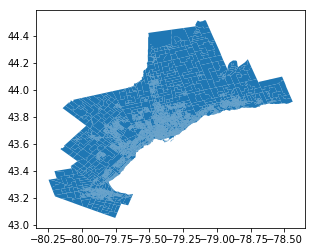

In [13]:
%%time
api_url = 'https://opendata.arcgis.com/datasets/9d262f8a576842fbb2afbc8c51a64178_1.geojson'
da_income_gdf = gpd.read_file(api_url)
da_income_gdf = da_income_gdf.set_index('OBJECTID').sort_index()
print("GeoDataFrame 'da_income_gdf' with profile of income by dissimination areas created!")
da_income_gdf.plot();

#### GeoDataFrame `'da_income_gdf'` -- profiles of income by DA from Census data

Indexed by `'OBJECTID'` -- id from dissimination area dataset

In [14]:
da_income_gdf.head()

DAUID   CSDUID CSDNAME  POP_TOT_INC  NUM_TOT_INC_PVT_HH  \
OBJECTID                                                               
1         35180171  3518013  Oshawa        410.0               390.0   
2         35180172  3518013  Oshawa        600.0               565.0   
3         35180173  3518013  Oshawa        435.0               415.0   
4         35180174  3518013  Oshawa        395.0               380.0   
5         35180175  3518013  Oshawa        390.0               365.0   

          MEDIAN_TOT_INC  NUM_AFT_TAX_INC_PVT_HH  MEDIAN_AFT_INC  \
OBJECTID                                                           
1                35456.0                   395.0         31360.0   
2                32725.0                   565.0         29440.0   
3                31744.0                   415.0         29888.0   
4                31744.0                   380.0         29184.0   
5                27669.0                   365.0         25792.0   

          NUM_MKT_INC_PVT_HH  MEDIAN_MKT_INC  \
OBJECTID                                       
1                      345.0         33536.0   
2                      485.0         32704.0   
3                      380.0         28864.0   
4                      335.0         28992.0   
5                      305.0         25504.0   

                                ...                          \
OBJECTID                        ...                           
1                               ...                           
2                               ...                           
3                               ...                           
4                               ...                           
5                               ...                           

          AVG_AFTER_TAX_INC_CPL_W_CHILD  TOT_INC_LONE_PARENT_25_SAMP  \
OBJECTID                                                               
1                               75791.0                         35.0   
2                               81505.0                         45.0   
3                               93490.0                         45.0   
4                               95730.0                         30.0   
5                               74522.0                         45.0   

          AVG_INC_LONE_PARENT  AVG_AFTER_TAX_LONE_PARENT  \
OBJECTID                                                   
1                     60196.0                    51430.0   
2                     77139.0                    66667.0   
3                     68103.0                    59910.0   
4                     68813.0                    60505.0   
5                     44117.0                    41120.0   

          TOT_INC_NOT_IN_ECF_25_SAMP  AVG_INC_NOT_IN_ECF  \
OBJECTID                                                   
1                              100.0             46557.0   
2                               70.0             32907.0   
3                               85.0             33680.0   
4                               55.0             37653.0   
5                               40.0             34721.0   

          AVG_AFTER_TAX_INC_NOT_IN_ECF    Shape__Area  Shape__Length  \
OBJECTID                                                               
1                              39470.0  167737.956787    1769.998586   
2                              29009.0  204952.632568    3307.399604   
3                              29573.0  115800.499512    1523.356568   
4                              32695.0  220872.362793    3404.150932   
5                              31025.0  897596.736572    5394.388445   

                                                   geometry  
OBJECTID                                                     
1         POLYGON ((-78.86262753067101 43.884693385047, ...  
2         POLYGON ((-78.8682185287246 43.8837638543214, ...  
3         POLYGON ((-78.8750195360013 43.8831881591365, ...  
4         POLYGON ((-78.8692322551675 43.8801945445542, ...  
5         POLYGON ((-78.8788

<a id='load_teranet'></a>
### 0.3 Load Teranet dataset with Dissimination Areas (verify path)

Back to [section 0](#preparations) / Back to the [top](#top)

> File path to Teranet dataset needs to be verified. 
>
>'..' means one directory up from the location of this notebook.

In [15]:
%%time

# verify the path to Teranet dataset
save_file_path = '../Data/HHSaleHistory_cleaned_v0.9_GTHA_DA.csv'   # .. means one directory up from current location 

# read Teranet dataset with a column containing Dissimination Areas id
teranet_da_df = pd.read_csv(save_file_path)
print("Full Teranet dataset read into DataFrame 'teranet_da_df' from file '{0}'".format(save_file_path))
print("\n{0:,} records total, including the ones with missing prices.".format(len(teranet_da_df)))

# drop rows with missing 'consideration_amt'
old_len = len(teranet_da_df)
teranet_da_df = teranet_da_df.dropna(subset=['consideration_amt'])\
                             .reset_index(drop=True)

print("\n---\n{0:,}({1:.2f}%) records with empty 'consideration_amt' were dropped from DataFrame 'teranet_da_df'."
      .format(old_len - len(teranet_da_df),
             (old_len - len(teranet_da_df)) / old_len * 100))
                                          
# drop unnecessary columns
cols_to_drop = ['Unnamed: 0', 'index', 'index_right']
teranet_da_df.drop(cols_to_drop, axis=1, inplace=True)
print("\n---\nThe following columns were dropped from the DataFrame 'teranet_da_df':\n", cols_to_drop)

# covert 'registration_date' to datetime data format
teranet_da_df['registration_date'] = pd.to_datetime(teranet_da_df['registration_date'])
print("\nValues in column 'registration_date' converted to datetime format.")

print("\n---------\n{0:,} records from the full cleaned Teranet dataset were loaded into DataFrame 'teranet_da_df'!"
      .format(len(teranet_da_df)))

Full Teranet dataset read into DataFrame 'teranet_da_df' from file '../Data/HHSaleHistory_cleaned_v0.9_GTHA_DA.csv'

6,062,853 records total, including the ones with missing prices.

---
1,425,269(23.51%) records with empty 'consideration_amt' were dropped from DataFrame 'teranet_da_df'.

---
The following columns were dropped from the DataFrame 'teranet_da_df':
 ['Unnamed: 0', 'index', 'index_right']

Values in column 'registration_date' converted to datetime format.

---------
4,637,584 records from the full cleaned Teranet dataset were loaded into DataFrame 'teranet_da_df'!
Wall time: 27.1 s


#### DataFrame `'teranet_da_df'` -- all records from Teranet dataset

Columns `'da_id'`, `'da_city'`, and `'da_median_tot_inc'` were previously added to the full clean Teranet dataset via a spatial join with the GeoDataFrame with the polygons of Dissimination Areas from GTHA (same GeoDataFrame as used in this script in [step 0.2](#load_da_gdf)). For more details, see jupyter notebook `'Teranet_GTHA_DA_spatial_join.ipynb'`.

In [16]:
teranet_da_df.head()

registration_date  decade  year  lro_num        pin  consideration_amt  \
0        1861-12-02     186  1861       62  174140491             3300.0   
1        1910-12-03     191  1910       62  174140099              200.0   
2        1966-11-14     196  1966       62  174140028            16250.0   
3        1985-09-18     198  1985       62  174140084            80000.0   
4        1985-09-30     198  1985       62  174140085            97500.0   

  postal_code province  unitno street_name street_designation  \
0         NaN       ON     NaN         NaN                NaN   
1         NaN       ON     NaN    Hwy 53 E                NaN   
2      L9G2J6       ON     NaN      Garden                Ave   
3      L9G2J9       ON     NaN      Garner                 Rd   
4      L9G2J9       ON     NaN      Garner                 Rd   

  street_direction municipality  street_suffix  street_number          x  \
0              NaN     Hamilton            NaN            NaN -79.977349   
1              NaN     Ancaster            NaN           99.0 -79.978293   
2              NaN     Ancaster            NaN           27.0 -79.981389   
3                E     Ancaster            NaN           63.0 -79.979511   
4                E     Hamilton            NaN           69.0 -79.979210   

           y  da_id   da_city  da_median_tot_inc  
0  43.203006   7504  Hamilton            46208.0  
1  43.202851   7504  Hamilton            46208.0  
2  43.203345   7504  Hamilton            46208.0  
3  43.202602   7504  Hamilton            46208.0  
4  43.202652   7504  Hamilton            46208.0

<a id='investigate_pins_2017'></a>
## 1. Investigate pins from the subset of Teranet records from 2017

Back to the [top](#top)

1.1 [Create a subset of Teranet records for 2017](#teranet_subset_2017)

1.2 [Perform the JOIN operation](#teranet_da_join)

1.3 [Approach 1 -- investigate `'pin'`s of Teranet records from DAs with the highest record count](#check_top_das)

1.4 [Approach 2 -- investigate `'pin'`s of condos of Teranet records from DAs located in downtown Toronto](#check_downtown_das)

---

This section investigates the `'pin'`s from Teranet records from 2017. The question is whether transactions of condos from the same building are recorded in Teranet dataset under the same `'pin'` or under different ones.  

#### Two approaches to investigate the `'pin'`s of condos in Teranet records

* create [subset by the highest count of records](#check_top_das) -- investigate the `'pin'`s of Teranet records from the top 20 DAs by count

    * take a subset of 1 year
    
        * unlikely to see a large number of resale of the same unit in 1 year
        
        * most transactions must be from different units of the same building

    * determine the top 20 DAs by count of Teranet records (high density of sales -- likely condos) 
    
    * take a subset of Teranet records from these DAs in 2017
    
    * investigate the number of unique `'pin'` values in the subset of Teranet records
    
    * most of these records must come from sales of condos, some must be from the same building
    
    
* create [subset spatially](#check_downtown_das) -- investigate the `'pin'`s of Teranet records from the downtown area

    * take a subset of 1 year

    * manually create a polygon highlighting downtown Toronto
    
    * use the polygon to perform a spatial join with DAs -- get a subset of DAs from downtown Toronto
    
    * use the subset of DAs to create a subset of Teranet records -- records from downtown DAs
    
    * investigate the number of unique `'pin'` values in the subset of Teranet records

    * there is a high number of high-rise condo buildings in the area highlighted by the polygon, many Teranet records must come from these buildings

<a id='teranet_subset_2017'></a>
### 1.1 Create a subset of Teranet records for 2017

Back to [section 1](#investigate_pins_2017) / Back to the [top](#top)

This script uses the function [`'subset_teranet'`](#subset_teranet)

In [17]:
%%time

# set start and end date for subsetting Teranet records
# (optinal) parameters to filter outliers can be adjusted inside of 'subset_teranet' call in this cell below
start_date = '2017-01-01'
end_date = '2017-12-31'

# call function 'subset_teranet' defined in step 0.1.4
# specify 'start_date' and 'end_date' for the subset
# (optional): select conditions to filter outliers
teranet_da_subset_df = subset_teranet(start_date=start_date, 
                                      end_date=end_date, 
                                      filter_top_outliers=False, # True to filter outliers with price > max_price
                                      max_price=50000,           # set max_price for the filter
                                      filter_bottom_outliers=False, # True to filter price < min_price
                                      min_price=5000000)         # set min_price for the filter


---
Returned DataFrame 'teranet_da_subset_df' with 153,126 records (out of the 4,637,584 total)
subset starting from '2017-01-01' to '2017-12-31'.

Wall time: 3.9 s


<a id='teranet_da_join'></a>
### 1.2 Make an aggregate from Teranet records and perform the JOIN operation with GeoDataFrame with DAs

Back to [section 1](#investigate_pins_2017) / Back to the [top](#top)

This script uses the function `'join_teranet_da'`

In [18]:
%%time
# call the function 'join_teranet_da' defined in (step 0.1.5)
# select the column to apply aggregating function to ('teranet_column_name'), 
# select the function to apply ('agg_func')
# and the name of the new column to be added to the GeoDataFrame with DAs ('agg_column_name'))
teranet_da_gdf = join_teranet_da(teranet_column_name='registration_date',
                                 agg_column_name='teranet_sales_count', 
                                 agg_func='count')

Teranet records have been aggregated using function 'count'
on values in column 'registration_date', Teranet records grouped using values in column 'da_id'.

---
Projection of Dissimination Areas (will be passed on to the new GeoDataFrame 'teranet_da_gdf'):
{'init': 'epsg:4326'}

Teranet aggregate joined on:
 Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182],
           dtype='int64', name='da_id', length=8717)

GeoDataFrame with DAs joined on:
 Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182],
           dtype='int64', name='OBJECTID', length=9182)

Teranet data aggregate JOINED to GeoDataFrame with Dissimination Areas on indexes!

---
Returning GeoDataFrame 'teranet_da_gdf' with DA geometry and a new column 'teranet_sales_count' with aggregate produced from Teranet r

<a id='check_top_das'></a>
### 1.3 Approach 1 -- investigate `'pin'`s of Teranet records from DAs with the highest record count

Back to [section 1](#investigate_pins_2017) / Back to the [top](#top)

Mapping top 20 Dissimination of areas by count of Teranet records in 2017, investigating unique `'pin'`s from Teranet records in this subset.

This script uses the function [map_top_das](#map_top_das)

#### Top 20 DAs by Teranet records count from the subset

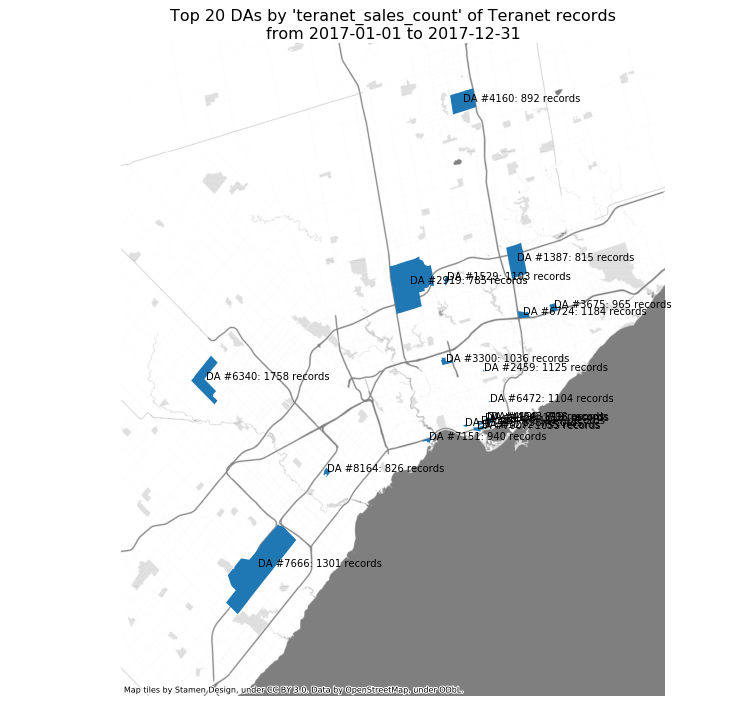

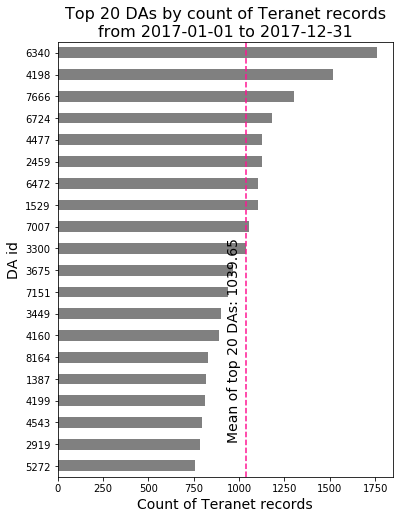


---
Out of 20,793 provided Teranet records, 20,057 (96.46%) have unique pins.

Records per 'pin' in the provided Teranet subset:

249293579    9
249292903    7
249293581    6
249293566    5
249293564    4
249293310    4
765730355    3
143650685    3
143652749    3
36424141     3
143644143    3
143652069    3
143643826    3
249293185    3
143650673    3
143650646    3
765840399    3
143650670    3
143643850    3
249293312    3
765560036    2
122600379    2
762670335    2
762670396    2
249291473    2
762670149    2
762670297    2
249293790    2
763550278    2
249293242    2
            ..
295840991    1
765811937    1
199380195    1
143652068    1
143643745    1
249294055    1
765730025    1
765560042    1
765660395    1
199800044    1
249294039    1
143643856    1
298760576    1
765930703    1
765840563    1
763100341    1
249291958    1
130090170    1
765660347    1
762590396    1
765930687    1
765811905    1
764331202    1
143652036    1
298660314    1
249294023    1
199630025    1

In [19]:
# call function 'map_top_das' defined in (step 0.1.3)
# min/max coordinate coefficients to zoom the map to Toronto
# minx_coef = 3.5, maxx_coef = 1.8, miny_coef = 2.8, maxy_coef = 1.5
map_top_das(start_date,
            end_date,
            da_num=20, 
            column='teranet_sales_count', 
            minx_coef=3.5, 
            maxx_coef=1.8, 
            miny_coef=2.8, 
            maxy_coef=1.5, 
            display_pin_counts=True)

<a id='check_downtown_das'></a>
### 1.4 Approach 2 -- investigate `'pin'`s of condos of Teranet records from DAs located in downtown Toronto

Back to [section 1](#determine_window) / Back to the [top](#top)

The workflow consists of **three main phases**:

1. [**Determine the window of interest**](#determine_window) to create a subset of **downtown condos** from Teranet data:

    * construct a polygon highlighting the zone of interest
    
        * high volume of sales coming from downtown Toronto
        
    * map a choropleth of [Teranet records overlayed with the polygon](#map_counts_and_polygon) of interest


2. Use the constructed polygon to create a subset of sales records coming from downtown DAs**

    * [perform the SPATIAL JOIN](#join_da_polygon) between DA GeoDataFrame and GeoDataFrame containing the polygon of interest conctructed at the end of step 1

    * get the list of DA id's that fall within the polygon of interest

    * use the list of DA is's to subset Teranet dataset to get a subset of sales coming from the polygon of interest


3. **[Investigate counts of sales per pin](#downtown_unique_pins)** from the subset 

<a id='determine_window'></a>
#### 1.4.1 Determine the window of interest

Back to [section 1.4](#check_downtown_das) / Back to [section 1](#investigate_pins_2017) / Back to the [top](#top)

* Polygon was created using coordinates generated manually from Google maps

* Coordinates have been selected manually to match a part of the high volume of sales zone in downtown area

* High volume of sales area has been identified visually from the map above

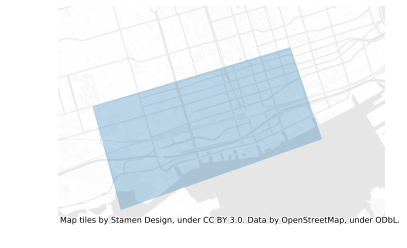

In [20]:
# create of tuple of points marking the corners of the polygon of interest
point_se = (-79.366842, 43.640514) # SE corner -- Sugar Beach
point_ne = (-79.373322, 43.653975) # NE corner -- Queen E north of Sugar Beach
point_nw = (-79.413201, 43.645317) # NW corner -- Queen W and Strachan
point_sw = (-79.407546, 43.630135) # SW corner -- Lakeshore and Strachan
points = (point_se, point_ne, point_nw, point_sw)

# create a GeoDataFrame of the polygon of interest
downtown_polygon_df = pd.DataFrame()
downtown_polygon_df.loc[0, 'name'] = 'Downtown'
downtown_polygon_df.loc[0, 'geometry'] = Polygon(points)
downtown_polygon_gdf = gpd.GeoDataFrame(downtown_polygon_df, geometry='geometry')
downtown_polygon_gdf.crs = {'init': 'epsg:4326', 'no_defs': True}

# plot the GeoDataFrame with the polygon of interest
f, ax = plt.subplots(1)
downtown_polygon_gdf.to_crs(epsg=3857).plot(ax=ax, alpha=0.3)
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_BACKGROUND, alpha=0.1)
ax.set_axis_off()
plt.show()

<a id='map_counts_and_polygon'></a>
#### 1.4.2 Verfify results: map Counts of Teranet records overlayed with polygon of interest

Back to [section 1.4](#check_downtown_das) / Back to [section 1](#investigate_pins_2017) / Back to the [top](#top)

#### Split using Fisher-Jenks optimization method

> * Balanced approach
>
>
> * Finds "natural" breaks in the distribution

This script uses functions [column_kde](#column_kde) and [column_choropleth](#column_choropleth) defined in steps [0.1.1](#column_kde) and [0.1.2](#column_choropleth) respectively. 

                 Fisher_Jenks                 
 
 Lower              Upper                Count
           x[i] <=   41.000               8182
  41.000 < x[i] <=  150.000                392
 150.000 < x[i] <=  427.000                104
 427.000 < x[i] <=  898.000                 27
 898.000 < x[i] <= 1758.000                 12


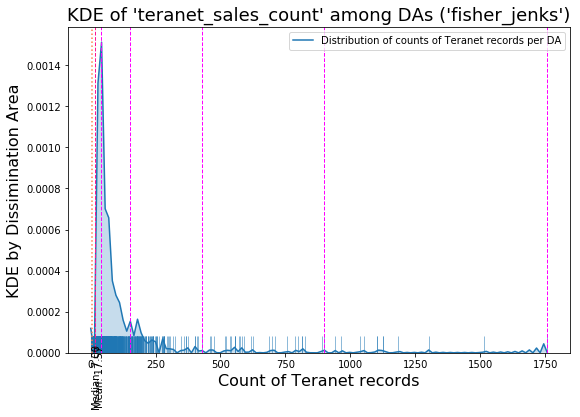

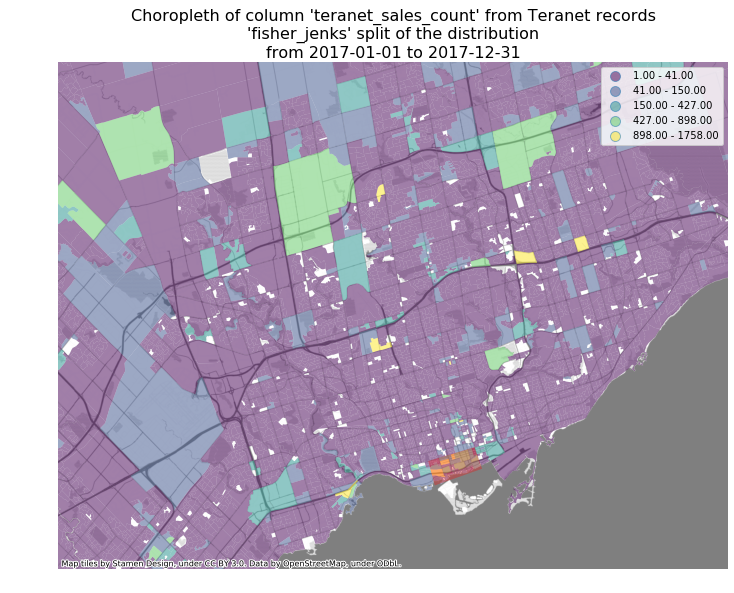

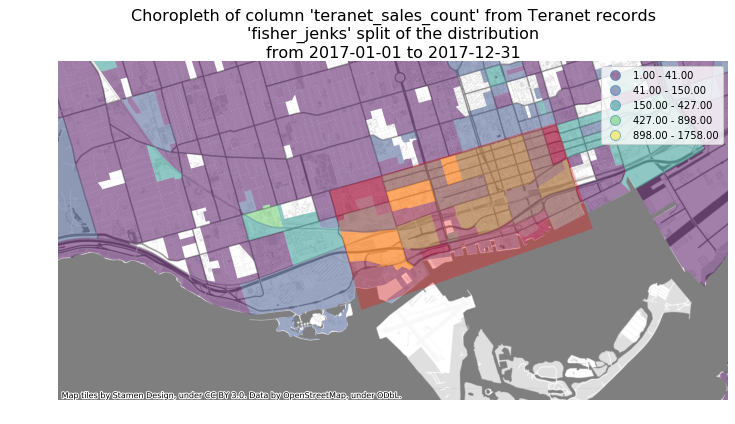

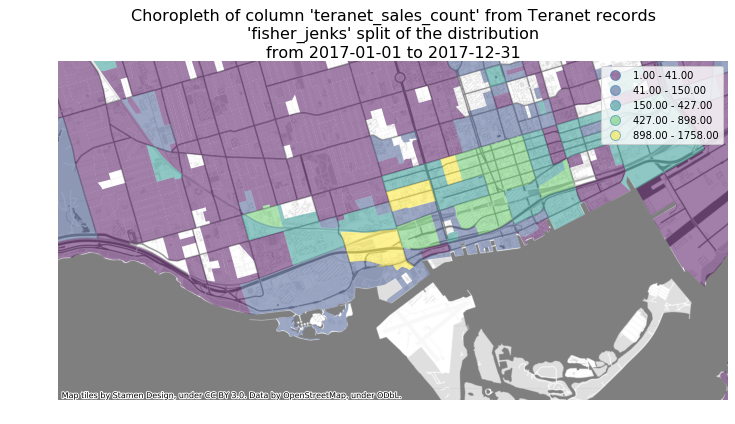

In [21]:
# set the column to plot
column_to_plot = 'teranet_sales_count'
# select the number of bins to be used for the split of the distribution of values in 'column_to_plot'
num_bins = 5
# select the type of the split to be performed on the distribution 
# must be 'quantiles', 'equal_interval', or 'fisher_jenks'
split_type= 'fisher_jenks'

# call the function 'column_kde' to plot KDE, rugplot, and the split of the distribution
column_kde(column_to_plot=column_to_plot, # column to plot
           num_bins=num_bins,             # number of bins to use for plotting the split of the distribution
           split_type=split_type,         # split type to be used
           bw=0.15)                       # bandwidth for KDE

# call the function 'column_choropleth' (defined in section 0.2) to plot the choropleth map of the distribution
# min/max coordinate coefficients to zoom the map to Toronto
# minx_coef = 3.5, maxx_coef = 1.8, miny_coef = 2.8, maxy_coef = 1.5
column_choropleth(column_to_plot=column_to_plot, # column to plot
                  num_bins=num_bins,      # number of bins to use for plotting the split of the distribution
                  split_type=split_type,  # split type to be used
                  polygon=True,           # plot the polygon of interest
                  minx_coef=3.5, 
                  maxx_coef=1.8, 
                  miny_coef=2.8, 
                  maxy_coef=1.5)

# call the function 'column_choropleth'
# min/max coordinate coefficients to zoom the map to downtown Toronto
# minx_coef = 2.3, maxx_coef = 1.13, miny_coef = 2.6, maxy_coef = 1.05
column_choropleth(column_to_plot=column_to_plot, 
                  num_bins=num_bins,     
                  split_type=split_type, 
                  polygon=True,          # plot the polygon of interest
                  minx_coef=2.3, 
                  maxx_coef=1.13, 
                  miny_coef=2.6, 
                  maxy_coef=1.05)

# call the function 'column_choropleth'
column_choropleth(column_to_plot=column_to_plot, 
                  num_bins=num_bins, 
                  split_type=split_type, 
                  polygon=False,         # don't plot the polygon of interest
                  minx_coef=2.3, 
                  maxx_coef=1.13, 
                  miny_coef=2.6, 
                  maxy_coef=1.05)

<a id='join_da_polygon'></a>
### 1.4.3 Perform SPATIAL JOIN of DAs with the polygon of interest

Back to [section 1.4](#check_downtown_das) / Back to [section 1](#investigate_pins_2017) / Back to the [top](#top)

* perform the SPATIAL JOIN between GeoDataFrame with DAs and GeoDataFrame containing the polygon of interest conctructed in [step 1.4.1](#determine_window)


* in addition to holding the aggregate values obtained from Teranet records in [step 1.4.2](#teranet_da_join), DA ids from the subset of DAs created by this SPATIAL JOIN will be used in the next step to subset Teranet records by `'da_id'` to investigate unique `'pin'`s among the sales


>This way, the SPATIAL JOIN only needs to be performed between ~9'000 DA polygons and 1 polygon of interest, and its result can be used to subset Teranet sales using a non-spatial JOIN operation in the next step, which drastically reduces computational requirements.

This script uses the function [`'da_polygon_sjoin'`](#da_polygon_sjoin).

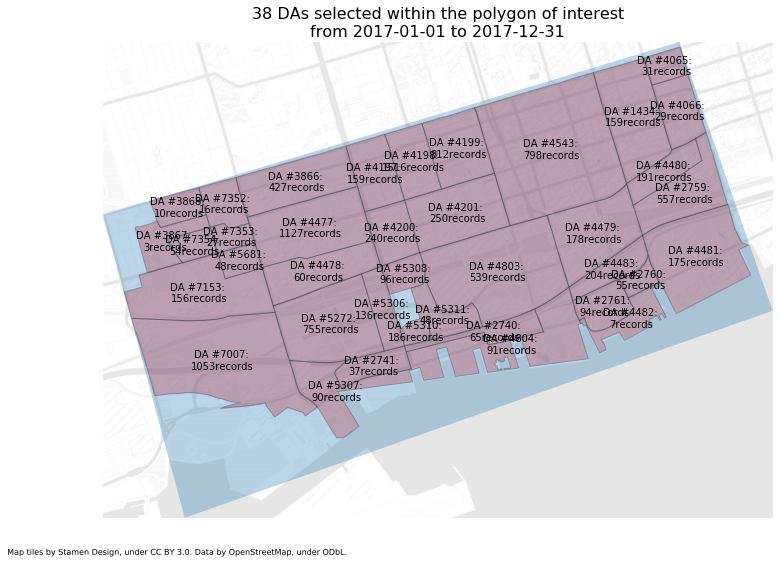

A subset with 38 DAs was created via a SPATIAL JOIN of GeoDataFrame 'teranet_da_gdf' and GeoDataFrame 'polygon_gdf'.
---

Top 5 DAs within the downtown polygon by 'teranet_sales_count':


teranet_sales_count     DAUID   CSDUID  CSDNAME  POP_TOT_INC  \
4198                 1516  35204842  3520005  Toronto       2500.0   
4477                 1127  35204894  3520005  Toronto       3555.0   
7007                 1053  35203157  3520005  Toronto       7410.0   
4199                  812  35204843  3520005  Toronto       2110.0   
4543                  798  35200855  3520005  Toronto       1120.0   

      NUM_TOT_INC_PVT_HH  MEDIAN_TOT_INC  NUM_AFT_TAX_INC_PVT_HH  \
4198              2430.0         54016.0                  2425.0   
4477              3520.0         67447.0                  3520.0   
7007              7265.0         49640.0                  7265.0   
4199              2085.0         52752.0                  2090.0   
4543              1075.0         63424.0                  1075.0   

      MEDIAN_AFT_INC  NUM_MKT_INC_PVT_HH    ...     AVG_INC_LONE_PARENT  \
4198         47008.0              2305.0    ...                     0.0   
4477         56121.0              3415.0    ...                     0.0   
7007         42963.0              6880.0    ...                 56650.0   
4199         45984.0              1980.0    ...                 79214.0   
4543         53888.0               995.0    ...                105216.0   

      AVG_AFTER_TAX_LONE_PARENT  TOT_INC_NOT_IN_ECF_25_SAMP  \
4198                        0.0                      1595.0   
4477                        0.0                      2005.0   
7007                    49749.0                      3535.0   
4199                    57731.0                      1215.0   
4543                        0.0                       375.0   

      AVG_INC_NOT_IN_ECF  AVG_AFTER_TAX_INC_NOT_IN_ECF    Shape__Area  \
4198             73991.0                       56658.0   82296.769287   
4477             90079.0                       67543.0  194657.082275   
7007             57748.0                       46742.0  383666.219971   
4199             66824.0                       53439.0  117156.195801   
4543            142605.0                       97592.0  472481.112793   

      Shape__Length                                           geometry  \
4198    1196.209880  POLYGON ((-79.3910882841223 43.6463175753544, ...   
4477    1889.764832  POLYGON ((-79.39908379882399 43.6431253934366,...   
7007    3087.679560  POLYGON ((-79.3983517853012 43.6356779795251, ...   
4199    1378.077693  POLYGON ((-79.3881446862095 43.6469693760702, ...   
4543    2726.874066  POLYGON ((-79.3840321803016 43.6449664831622, ...   

      index_right      name  
4198            0  Downtown  
4477            0  Downtown  
7007            0  Downtown  
4199            0  Downtown  
4543            0  Downtown  

[5 rows x 220 columns]

In [22]:
teranet_da_downtown_gdf = da_polygon_sjoin(downtown_polygon_gdf,
                                           annotate_column=True,
                                           ann_col_name='teranet_sales_count',
                                           ann_label='records',
                                           start_date=start_date,
                                           end_date=end_date)
print("Top 5 DAs within the downtown polygon by 'teranet_sales_count':")
teranet_da_downtown_gdf.sort_values('teranet_sales_count', ascending=False).head()

<a id='downtown_unique_pins'></a>
### 1.4.4 Investigate unique pins among Teranet records from downtown DAs

Back to [section 1.4](#check_downtown_das) / Back to [section 1](#investigate_pins_2017) / Back to the [top](#top)

This script uses functions [crop_teranet_daid](#crop_teranet_daid) and [unique_pins](#unique_pins)

In [23]:
# specify the subset of 'da_id's to "crop" Teranet subset by (downtown DAs)
da_subset = teranet_da_downtown_gdf.index 

# call the function 'crop_teranet_daid' defined in (step 0.1.7)
teranet_da_subset_df_cropped = crop_teranet_daid(da_subset, 
                                                 start_date, 
                                                 end_date)

# call the function 'unique_pins' on the "cropped" Teranet subset to investigate unique pins in downtown DAs
unique_pins(teranet_da_subset_df_cropped)

Teranet records "cropped" by Dissimination Area ids from the list provided.
---
Out of total 153,126 Teranet records from 2017-01-01 to 2017-12-31, 10,479 were found in 38 provided Dissimination Areas.

Returned 10,479 (6.84%) records remaining out of 153,126 total from 2017-01-01 to 2017-12-31 after "cropping" by "da_id".

---
Out of 10,479 provided Teranet records, 10,092 (96.31%) have unique pins.

Records per 'pin' in the provided Teranet subset:

765840399    3
765730355    3
763080419    3
762670275    2
762670306    2
762670168    2
762670335    2
765102043    2
762670314    2
762670190    2
762670203    2
765600360    2
765850194    2
762670160    2
762670182    2
762670152    2
765102849    2
762670174    2
762670290    2
762670198    2
765600887    2
762670227    2
765600091    2
762670362    2
762670192    2
762670354    2
125550153    2
762670222    2
762670184    2
762670346    2
            ..
765850163    1
761811503    1
115970081    1
125170186    1
765600297    1
1271

<a id='investigate_pins_2010'></a>
## 2. Investigate pins from the subset of Teranet records from 2010

Back to the [top](#top)

2.1 [Create a subset of Teranet records for 2010](#teranet_subset_2010)

2.2 [Perform the JOIN operation](#teranet_da_join_2010)

2.3 [Approach 1 -- investigate `'pin'`s of Teranet records from DAs with the highest record count](#check_top_das_2010)

2.4 [Approach 2 -- investigate `'pin'`s of condos of Teranet records from DAs located in downtown Toronto](#check_downtown_das_2010)

---

This section investigates the `'pin'`s from Teranet records from 2010. 

It repeats the same workflow as presented in [section 1](#investigate_pins_2017).

<a id='teranet_subset_2010'></a>
### 2.1 Create a subset of Teranet records for 2010

Back to [section 2](#investigate_pins_2010) / Back to the [top](#top)

This script uses the function `'subset_teranet'` defined in [step 0.1.4](#subset_teranet).

In [24]:
%%time

# set start and end date for subsetting Teranet records
# (optinal) parameters to filter outliers can be adjusted inside of 'subset_teranet' call in this cell below
start_date = '2010-01-01'
end_date = '2010-12-31'

# call function 'subset_teranet' defined in step 0.1.4
# specify 'start_date' and 'end_date' for the subset
# (optional): select conditions to filter outliers
teranet_da_subset_df = subset_teranet(start_date=start_date, 
                                      end_date=end_date, 
                                      filter_top_outliers=False, # True to filter outliers with price > max_price
                                      max_price=50000,           # set max_price for the filter
                                      filter_bottom_outliers=False, # True to filter price < min_price
                                      min_price=5000000)         # set min_price for the filter


---
Returned DataFrame 'teranet_da_subset_df' with 187,260 records (out of the 4,637,584 total)
subset starting from '2010-01-01' to '2010-12-31'.

Wall time: 4.51 s


<a id='teranet_da_join_2010'></a>
### 2.2 Make an aggregate from Teranet records and perform the JOIN operation with GeoDataFrame with DAs

Back to [section 2](#investigate_pins_2010) / Back to the [top](#top)

This script uses the function `'join_teranet_da'` defined in [step 0.1.5](#join_teranet_da).

In [25]:
%%time
# call the function 'join_teranet_da' defined in (step 0.1.5)
# select the column to apply aggregating function to ('teranet_column_name'), 
# select the function to apply ('agg_func')
# and the name of the new column to be added to the GeoDataFrame with DAs ('agg_column_name'))
teranet_da_gdf = join_teranet_da(teranet_column_name='registration_date',
                                 agg_column_name='teranet_sales_count', 
                                 agg_func='count')

Teranet records have been aggregated using function 'count'
on values in column 'registration_date', Teranet records grouped using values in column 'da_id'.

---
Projection of Dissimination Areas (will be passed on to the new GeoDataFrame 'teranet_da_gdf'):
{'init': 'epsg:4326'}

Teranet aggregate joined on:
 Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            9172, 9173, 9174, 9175, 9177, 9178, 9179, 9180, 9181, 9182],
           dtype='int64', name='da_id', length=8863)

GeoDataFrame with DAs joined on:
 Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182],
           dtype='int64', name='OBJECTID', length=9182)

Teranet data aggregate JOINED to GeoDataFrame with Dissimination Areas on indexes!

---
Returning GeoDataFrame 'teranet_da_gdf' with DA geometry and a new column 'teranet_sales_count' with aggregate produced from Teranet r

<a id='check_top_das_2010'></a>
### 2.3 Approach 1 -- investigate `'pin'`s of Teranet records from DAs with the highest record count

Back to [section 2](#investigate_pins_2010) / Back to the [top](#top)

Mapping top 20 Dissimination of areas by count of Teranet records, investigating unique `'pin'`s from Teranet records in this subset.

This script uses the function [map_top_das](#map_top_das) defined in [step 0.1.3](#map_top_das).

#### Top 20 DAs by Teranet records count from the subset

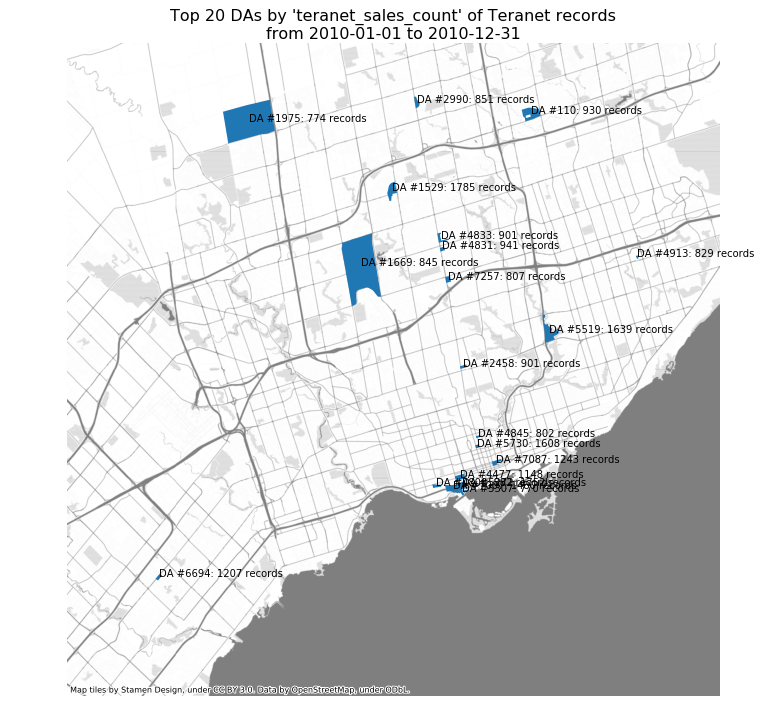

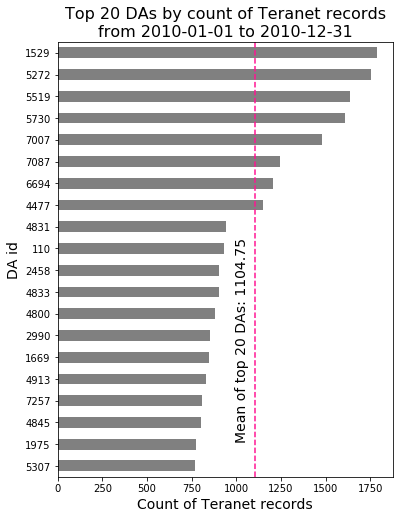


---
Out of 22,095 provided Teranet records, 20,440 (92.51%) have unique pins.

Records per 'pin' in the provided Teranet subset:

211360440    4
130440727    3
130371765    3
130440005    3
297060400    3
33276872     3
297050139    3
130371728    3
130371557    3
130640128    3
33275864     3
130480198    3
33276857     3
130370715    3
130370496    3
130640176    3
130640387    3
130440325    2
297140210    2
130580363    2
130901122    2
130370679    2
130371249    2
130440333    2
130370010    2
761071026    2
761190744    2
130870225    2
130440341    2
130430104    2
            ..
761210919    1
130900838    1
127540073    1
761070442    1
124040044    1
210910061    1
761210864    1
293000048    1
130440049    1
130370419    1
761070426    1
130900822    1
130970746    1
130370387    1
129770223    1
297140168    1
761090393    1
130820280    1
129770302    1
761210424    1
130440001    1
130970436    1
33276108     1
130900806    1
127540041    1
129770318    1
761030570    1

In [26]:
# call function 'map_top_das' defined in (step 0.1.3)
# min/max coordinate coefficients to zoom the map to Toronto
# minx_coef = 3.5, maxx_coef = 1.8, miny_coef = 2.8, maxy_coef = 1.5
map_top_das(start_date,
            end_date,
            da_num=20, 
            column='teranet_sales_count', 
            minx_coef=3.5, 
            maxx_coef=1.8, 
            miny_coef=2.8, 
            maxy_coef=1.5, 
            display_pin_counts=True)

<a id='check_downtown_das_2010'></a>
### 2.4 Approach 2 -- investigate `'pin'`s of condos of Teranet records from DAs located in downtown Toronto

Back to [section 2](#investigate_pins_2010) / Back to the [top](#top)

This section uses the polygon of interest previously defined in [step 1.4.1](#determine_window) to perform the [SPATIAL JOIN](#join_da_polygon_2010) of GeoDataFrame with DAs and investigate [unique pins](#downtown_unique_pins_2010).

<a id='join_da_polygon_2010'></a>
### 2.4.1 Perform SPATIAL JOIN of DAs with the polygon of interest

Back to [section 2.4](#check_downtown_das_2010) / Back to [section 2](#investigate_pins_2010) / Back to the [top](#top)

* perform the SPATIAL JOIN between GeoDataFrame with DAs and GeoDataFrame containing the polygon of interest conctructed in [step 1.4.1](#determine_window)

This script uses the function [`'da_polygon_sjoin'`](#da_polygon_sjoin).

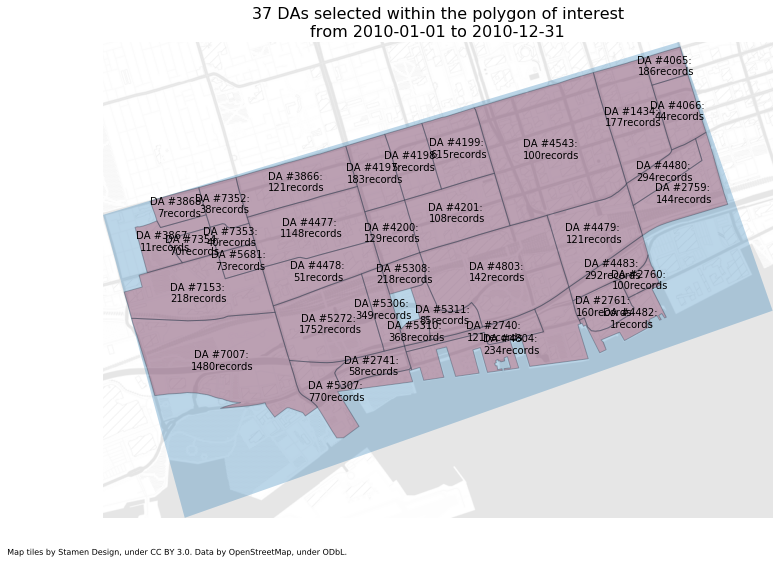

A subset with 37 DAs was created via a SPATIAL JOIN of GeoDataFrame 'teranet_da_gdf' and GeoDataFrame 'polygon_gdf'.
---

Top 5 DAs within the downtown polygon by 'teranet_sales_count':


teranet_sales_count     DAUID   CSDUID  CSDNAME  POP_TOT_INC  \
5272                 1752  35204819  3520005  Toronto       6215.0   
7007                 1480  35203157  3520005  Toronto       7410.0   
4477                 1148  35204894  3520005  Toronto       3555.0   
5307                  770  35204821  3520005  Toronto        945.0   
4199                  615  35204843  3520005  Toronto       2110.0   

      NUM_TOT_INC_PVT_HH  MEDIAN_TOT_INC  NUM_AFT_TAX_INC_PVT_HH  \
5272              6010.0         36512.0                  6010.0   
7007              7265.0         49640.0                  7265.0   
4477              3520.0         67447.0                  3520.0   
5307               925.0         51925.0                   925.0   
4199              2085.0         52752.0                  2090.0   

      MEDIAN_AFT_INC  NUM_MKT_INC_PVT_HH    ...     AVG_INC_LONE_PARENT  \
5272         33352.0              5425.0    ...                 56991.0   
7007         42963.0              6880.0    ...                 56650.0   
4477         56121.0              3415.0    ...                     0.0   
5307         44608.0               885.0    ...                     0.0   
4199         45984.0              1980.0    ...                 79214.0   

      AVG_AFTER_TAX_LONE_PARENT  TOT_INC_NOT_IN_ECF_25_SAMP  \
5272                    50899.0                      3035.0   
7007                    49749.0                      3535.0   
4477                        0.0                      2005.0   
5307                        0.0                       465.0   
4199                    57731.0                      1215.0   

      AVG_INC_NOT_IN_ECF  AVG_AFTER_TAX_INC_NOT_IN_ECF    Shape__Area  \
5272             48362.0                       40057.0  210669.039551   
7007             57748.0                       46742.0  383666.219971   
4477             90079.0                       67543.0  194657.082275   
5307             59250.0                       47941.0  103315.808105   
4199             66824.0                       53439.0  117156.195801   

      Shape__Length                                           geometry  \
5272    1824.917108  POLYGON ((-79.4002787239359 43.6380235337235, ...   
7007    3087.679560  POLYGON ((-79.3983517853012 43.6356779795251, ...   
4477    1889.764832  POLYGON ((-79.39908379882399 43.6431253934366,...   
5307    2350.619400  POLYGON ((-79.3917595467445 43.6369539059585, ...   
4199    1378.077693  POLYGON ((-79.3881446862095 43.6469693760702, ...   

      index_right      name  
5272            0  Downtown  
7007            0  Downtown  
4477            0  Downtown  
5307            0  Downtown  
4199            0  Downtown  

[5 rows x 220 columns]

In [27]:
teranet_da_downtown_gdf = da_polygon_sjoin(downtown_polygon_gdf,
                                           annotate_column=True,
                                           ann_col_name='teranet_sales_count',
                                           ann_label='records',
                                           start_date=start_date,
                                           end_date=end_date)
print("Top 5 DAs within the downtown polygon by 'teranet_sales_count':")
teranet_da_downtown_gdf.sort_values('teranet_sales_count', ascending=False).head()

<a id='downtown_unique_pins_2010'></a>
### 2.4.2 Investigate unique pins among Teranet records from downtown DAs

Back to [section 2.4](#check_downtown_das_2010) / Back to [section 2](#investigate_pins_2010) / Back to the [top](#top)

This script uses the function [crop_teranet_daid](#crop_teranet_daid)

In [28]:
# specify the subset of 'da_id's to "crop" Teranet subset by (downtown DAs)
da_subset = teranet_da_downtown_gdf.index 

# call the function 'crop_teranet_daid' defined in (step 0.1.7)
teranet_da_subset_df_cropped = crop_teranet_daid(da_subset, 
                                                 start_date, 
                                                 end_date)

# call the function 'unique_pins' on the "cropped" Teranet subset to investigate unique pins in downtown DAs
unique_pins(teranet_da_subset_df_cropped)

Teranet records "cropped" by Dissimination Area ids from the list provided.
---
Out of total 187,260 Teranet records from 2010-01-01 to 2010-12-31, 10,013 were found in 37 provided Dissimination Areas.

Returned 10,013 (5.35%) records remaining out of 187,260 total from 2010-01-01 to 2010-12-31 after "cropping" by "da_id".

---
Out of 10,013 provided Teranet records, 9,601 (95.89%) have unique pins.

Records per 'pin' in the provided Teranet subset:

214110169    3
130610261    3
130610730    3
130970654    2
130950279    2
130950271    2
130900558    2
130160796    2
130900573    2
761020514    2
130350320    2
130900581    2
130820266    2
130900684    2
130970204    2
761020328    2
123250056    2
130900127    2
761020559    2
130760067    2
130900083    2
130900510    2
761020433    2
130950257    2
130970107    2
130350083    2
130970238    2
130090362    2
130610594    2
130820218    2
            ..
130300386    1
130900449    1
130820576    1
130610240    1
130900457    1
13090

<a id='investigate_pins_2010-2017'></a>
## 3. Investigate pins from the subset of Teranet records from 2010-2017

Back to the [top](#top)

3.1 [Create a subset of Teranet records for 2010-2017](#teranet_subset_2010-2017)

3.2 [Perform the JOIN operation](#teranet_da_join_2010-2017)

3.3 [Approach 1 -- investigate `'pin'`s of Teranet records from DAs with the highest record count](#check_top_das_2010-2017)

3.4 [Approach 2 -- investigate `'pin'`s of condos of Teranet records from DAs located in downtown Toronto](#check_downtown_das_2010-2017)

---

This section investigates the `'pin'`s from Teranet records from 2010 to 2017. 

It repeats the same workflow as presented in [section 1](#investigate_pins_2017).

<a id='teranet_subset_2010-2017'></a>
### 3.1 Create a subset of Teranet records for 2010-2017

Back to [section 3](#investigate_pins_2010-2017) / Back to the [top](#top)

This script uses the function `'subset_teranet'` defined in [step 0.1.4](#subset_teranet).

In [29]:
%%time

# set start and end date for subsetting Teranet records
# (optinal) parameters to filter outliers can be adjusted inside of 'subset_teranet' call in this cell below
start_date = '2010-01-01'
end_date = '2017-12-31'

# call function 'subset_teranet' defined in step 0.1.4
# specify 'start_date' and 'end_date' for the subset
# (optional): select conditions to filter outliers
teranet_da_subset_df = subset_teranet(start_date=start_date, 
                                      end_date=end_date, 
                                      filter_top_outliers=False, # True to filter outliers with price > max_price
                                      max_price=50000,           # set max_price for the filter
                                      filter_bottom_outliers=False, # True to filter price < min_price
                                      min_price=5000000)         # set min_price for the filter


---
Returned DataFrame 'teranet_da_subset_df' with 1,507,746 records (out of the 4,637,584 total)
subset starting from '2010-01-01' to '2017-12-31'.

Wall time: 4.17 s


<a id='teranet_da_join_2010-2017'></a>
### 3.2 Make an aggregate from Teranet records and perform the JOIN operation with GeoDataFrame with DAs

Back to [section 3](#investigate_pins_2010-2017) / Back to the [top](#top)

This script uses the function `'join_teranet_da'` defined in [step 0.1.5](#join_teranet_da).

In [30]:
%%time
# call the function 'join_teranet_da' defined in (step 0.1.5)
# select the column to apply aggregating function to ('teranet_column_name'), 
# select the function to apply ('agg_func')
# and the name of the new column to be added to the GeoDataFrame with DAs ('agg_column_name'))
teranet_da_gdf = join_teranet_da(teranet_column_name='registration_date',
                                 agg_column_name='teranet_sales_count', 
                                 agg_func='count')

Teranet records have been aggregated using function 'count'
on values in column 'registration_date', Teranet records grouped using values in column 'da_id'.

---
Projection of Dissimination Areas (will be passed on to the new GeoDataFrame 'teranet_da_gdf'):
{'init': 'epsg:4326'}

Teranet aggregate joined on:
 Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182],
           dtype='int64', name='da_id', length=9056)

GeoDataFrame with DAs joined on:
 Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182],
           dtype='int64', name='OBJECTID', length=9182)

Teranet data aggregate JOINED to GeoDataFrame with Dissimination Areas on indexes!

---
Returning GeoDataFrame 'teranet_da_gdf' with DA geometry and a new column 'teranet_sales_count' with aggregate produced from Teranet r

<a id='check_top_das_2010-2017'></a>
### 3.3 Approach 1 -- investigate `'pin'`s of Teranet records from DAs with the highest record count

Back to [section 3](#investigate_pins_2010-2017) / Back to the [top](#top)

Mapping top 20 Dissimination of areas by count of Teranet records, investigating unique `'pin'`s from Teranet records in this subset.

This script uses the function [map_top_das](#map_top_das) defined in [step 0.1.3](#map_top_das).

#### Top 20 DAs by Teranet records count from the subset

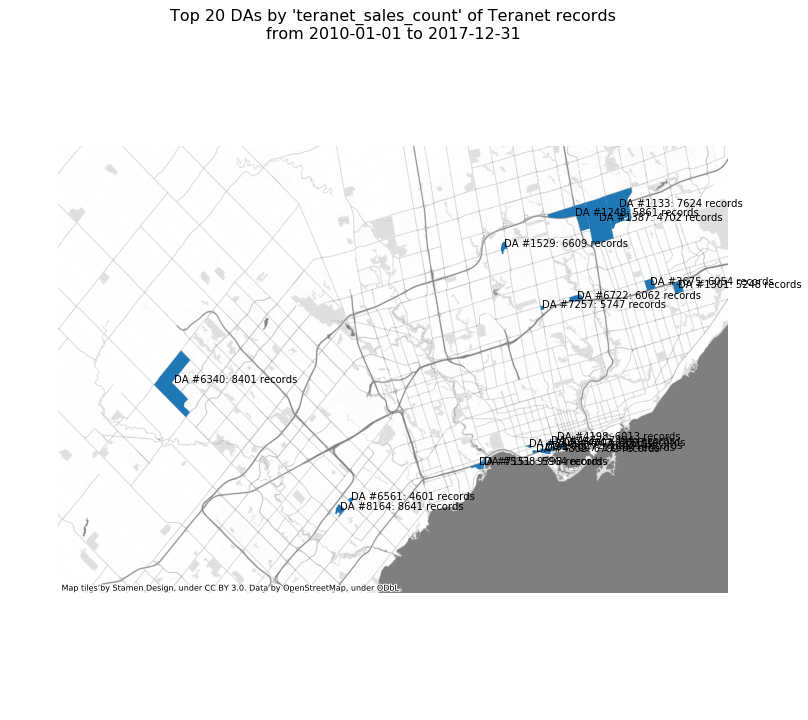

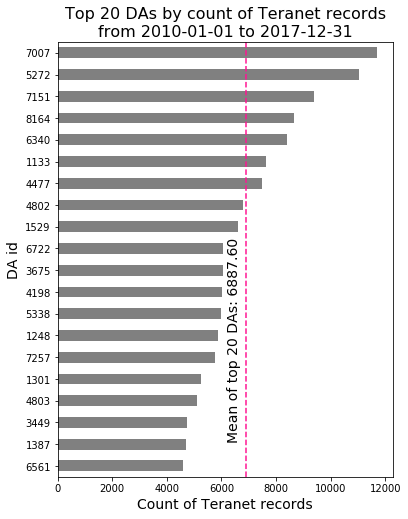


---
Out of 137,752 provided Teranet records, 101,258 (73.51%) have unique pins.

Records per 'pin' in the provided Teranet subset:

130820606    6
130820195    6
130901373    5
120231078    5
130820264    5
296970426    5
143642496    5
121510494    5
143642441    5
120230490    5
143642476    5
143642507    5
143642504    5
761770267    5
143641296    5
761530607    5
130820336    5
130900452    5
143641340    5
143642478    5
143642768    5
143641323    5
121510432    5
761530125    5
296940122    5
294680026    5
296060112    4
297060554    4
130820233    4
762500251    4
            ..
199460413    1
763760140    1
198940223    1
761810500    1
765470281    1
127680074    1
764950091    1
29890127     1
764160123    1
143650906    1
130950665    1
199460285    1
294170072    1
198940095    1
294680003    1
764960198    1
199380963    1
764431368    1
762590667    1
129891045    1
761570777    1
764321214    1
764710364    1
764190174    1
126430696    1
764481004    1
199300591   

In [31]:
# call function 'map_top_das' defined in (step 0.1.3)
# min/max coordinate coefficients to zoom the map to Toronto
# minx_coef = 3.5, maxx_coef = 1.8, miny_coef = 2.8, maxy_coef = 1.5
map_top_das(start_date,
            end_date,
            da_num=20, 
            column='teranet_sales_count', 
            minx_coef=3.5, 
            maxx_coef=1.8, 
            miny_coef=2.8, 
            maxy_coef=1.5, 
            display_pin_counts=True)

<a id='check_downtown_das_2010-2017'></a>
### 3.4 Approach 2 -- investigate `'pin'`s of condos of Teranet records from DAs located in downtown Toronto

Back to [section 3](#investigate_pins_2010-2017) / Back to the [top](#top)

This section uses the polygon of interest previously defined in [step 1.4.1](#determine_window) to perform the [SPATIAL JOIN](#join_da_polygon_2010-2017) of GeoDataFrame with DAs and investigate [unique pins](#downtown_unique_pins_2010-2017).

<a id='join_da_polygon_2010-2017'></a>
### 3.4.1 Perform SPATIAL JOIN of DAs with the polygon of interest

Back to [section 3.4](#check_downtown_das_2010-2017) / Back to [section 3](#investigate_pins_2010-2017) / Back to the [top](#top)

* perform the SPATIAL JOIN between GeoDataFrame with DAs and GeoDataFrame containing the polygon of interest conctructed in [step 1.4.1](#determine_window)

This script uses the function [`'da_polygon_sjoin'`](#da_polygon_sjoin).

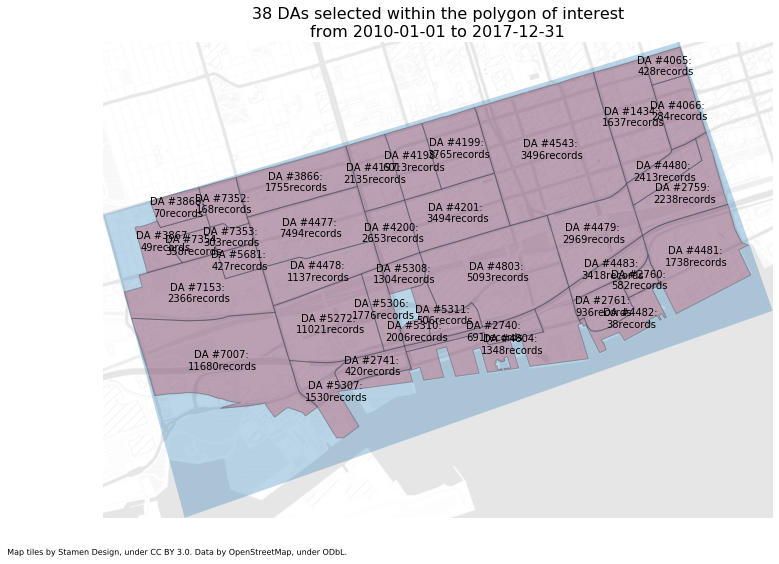

A subset with 38 DAs was created via a SPATIAL JOIN of GeoDataFrame 'teranet_da_gdf' and GeoDataFrame 'polygon_gdf'.
---

Top 5 DAs within the downtown polygon by 'teranet_sales_count':


teranet_sales_count     DAUID   CSDUID  CSDNAME  POP_TOT_INC  \
7007                11680  35203157  3520005  Toronto       7410.0   
5272                11021  35204819  3520005  Toronto       6215.0   
4477                 7494  35204894  3520005  Toronto       3555.0   
4198                 6013  35204842  3520005  Toronto       2500.0   
4803                 5093  35204826  3520005  Toronto       3435.0   

      NUM_TOT_INC_PVT_HH  MEDIAN_TOT_INC  NUM_AFT_TAX_INC_PVT_HH  \
7007              7265.0         49640.0                  7265.0   
5272              6010.0         36512.0                  6010.0   
4477              3520.0         67447.0                  3520.0   
4198              2430.0         54016.0                  2425.0   
4803              3350.0         50660.0                  3350.0   

      MEDIAN_AFT_INC  NUM_MKT_INC_PVT_HH    ...     AVG_INC_LONE_PARENT  \
7007         42963.0              6880.0    ...                 56650.0   
5272         33352.0              5425.0    ...                 56991.0   
4477         56121.0              3415.0    ...                     0.0   
4198         47008.0              2305.0    ...                     0.0   
4803         44940.0              3195.0    ...                 91283.0   

      AVG_AFTER_TAX_LONE_PARENT  TOT_INC_NOT_IN_ECF_25_SAMP  \
7007                    49749.0                      3535.0   
5272                    50899.0                      3035.0   
4477                        0.0                      2005.0   
4198                        0.0                      1595.0   
4803                    77606.0                      1835.0   

      AVG_INC_NOT_IN_ECF  AVG_AFTER_TAX_INC_NOT_IN_ECF    Shape__Area  \
7007             57748.0                       46742.0  383666.219971   
5272             48362.0                       40057.0  210669.039551   
4477             90079.0                       67543.0  194657.082275   
4198             73991.0                       56658.0   82296.769287   
4803             58186.0                       47176.0  329294.806396   

      Shape__Length                                           geometry  \
7007    3087.679560  POLYGON ((-79.3983517853012 43.6356779795251, ...   
5272    1824.917108  POLYGON ((-79.4002787239359 43.6380235337235, ...   
4477    1889.764832  POLYGON ((-79.39908379882399 43.6431253934366,...   
4198    1196.209880  POLYGON ((-79.3910882841223 43.6463175753544, ...   
4803    2382.073480  POLYGON ((-79.38330616566 43.6405982849749, -7...   

      index_right      name  
7007            0  Downtown  
5272            0  Downtown  
4477            0  Downtown  
4198            0  Downtown  
4803            0  Downtown  

[5 rows x 220 columns]

In [32]:
teranet_da_downtown_gdf = da_polygon_sjoin(downtown_polygon_gdf,
                                           annotate_column=True,
                                           ann_col_name='teranet_sales_count',
                                           ann_label='records',
                                           start_date=start_date,
                                           end_date=end_date)
print("Top 5 DAs within the downtown polygon by 'teranet_sales_count':")
teranet_da_downtown_gdf.sort_values('teranet_sales_count', ascending=False).head()

<a id='downtown_unique_pins_2010-2017'></a>
### 3.4.2 Investigate unique pins among Teranet records from downtown DAs

Back to [section 3.4](#check_downtown_das_2010-2017) / Back to [section 3](#investigate_pins_2010-2017) / Back to the [top](#top)

This script uses the function [crop_teranet_daid](#crop_teranet_daid)

In [33]:
# specify the subset of 'da_id's to "crop" Teranet subset by (downtown DAs)
da_subset = teranet_da_downtown_gdf.index 

# call the function 'crop_teranet_daid' defined in (step 0.1.7)
teranet_da_subset_df_cropped = crop_teranet_daid(da_subset, 
                                                 start_date, 
                                                 end_date)

# call the function 'unique_pins' on the "cropped" Teranet subset to investigate unique pins in downtown DAs
unique_pins(teranet_da_subset_df_cropped)

Teranet records "cropped" by Dissimination Area ids from the list provided.
---
Out of total 1,507,746 Teranet records from 2010-01-01 to 2017-12-31, 89,739 were found in 38 provided Dissimination Areas.

Returned 89,739 (5.95%) records remaining out of 1,507,746 total from 2010-01-01 to 2017-12-31 after "cropping" by "da_id".

---
Out of 89,739 provided Teranet records, 68,643 (76.49%) have unique pins.

Records per 'pin' in the provided Teranet subset:

130820195    6
130820606    6
761300557    5
212390507    5
130820336    5
125170325    5
130820264    5
212390486    5
130760056    5
761301310    5
130901373    5
130900452    5
130900827    4
762500176    4
130900411    4
130820824    4
761020141    4
130760134    4
128480465    4
115100580    4
130350136    4
130970309    4
130900861    4
127641461    4
761300074    4
120460022    4
761020161    4
761811503    4
129280027    4
130820680    4
            ..
765340139    1
763460232    1
130900619    1
763460296    1
763011763    1
